In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from math import *
import sys
from skimage import io
from time import clock,time
import pandas as pd
from scipy.interpolate import Rbf
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
from itertools import product
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import CubicSpline
from itertools import product


# Experiments

### 1. Linear Upwind Scheme

In [2]:
# https://github.com/smm8ec/am205-ssmodel/blob/master/paperbucket/more_schemes.pdf
# SEE PAGE 4 FOR NUMERICAL SCHEME
# mock data
tsteps = 100 # steps into the future
asteps = 20 # steps between age groups
A = 6 # species has lifespan 0-6
T = 10 # a 10 year projection
mu = .05 # assume constant death rate independent of age

# generate grid
t_range = np.linspace(0,T,tsteps)
x_range = np.linspace(0,A,asteps)
deltat = t_range[1]-t_range[0]
deltax = x_range[1]-x_range[0]
nu = deltat/float(deltax)
age_wave = np.zeros((len(x_range),len(t_range)))


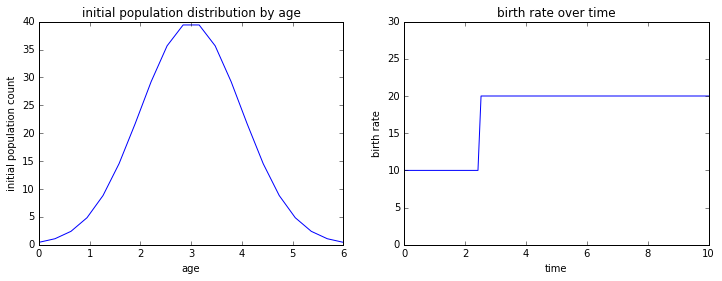

In [3]:
# more mock data
# initial population distribution across age buckets
phi0 = [norm.pdf(x-3)*100 for x in x_range]
# initial birth rate
B0 = []
for t in t_range:
    if t>T/4.:
        B0.append(20)
    else:
        B0.append(10)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('initial population distribution by age')
plt.plot(x_range,phi0)
plt.xlabel('age')
plt.ylabel('initial population count')
plt.subplot(1,2,2)
plt.title('birth rate over time')
plt.plot(t_range,B0)
plt.xlabel('time')
plt.ylabel('birth rate')
plt.ylim([0,30]);

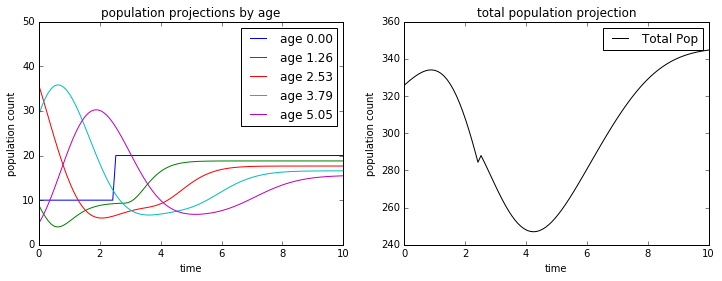

In [4]:
# initialize grid with population and birth rates
age_wave[:,0] = phi0
age_wave[0,:] = B0

# upwind scheme
for n in range(1,age_wave.shape[1]):
    for j in range(1,age_wave.shape[0]):
        age_wave[j,n] = age_wave[j,n-1] - nu*(age_wave[j,n-1] - age_wave[j-1,n-1]) - deltat*mu*age_wave[j,n-1]
        
# plot population projections by age
plt.figure(figsize=(12,4))
for ind, a in enumerate(x_range):
    if ind%4==0:
        plt.subplot(1,2,1)
        plt.plot(t_range, age_wave[ind,:], label='age %0.2f'% a)
plt.title('population projections by age')
plt.xlabel('time')
plt.ylabel('population count')
plt.ylim([0,50])
plt.legend()

# plot total population
plt.subplot(1,2,2)
P =[np.sum(age_wave[:,t]) for t in range(len(t_range))]
plt.plot(t_range,P,label='Total Pop',color='black')
plt.title('total population projection')
plt.xlabel('time')
plt.ylabel('population count')
plt.legend()


### 2. Non-linear upwind scheme - error analysis

### 2i. Analytical Benchmark

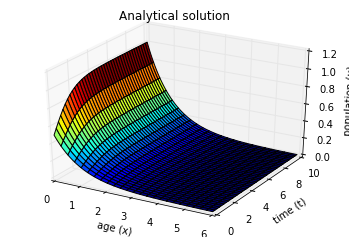

In [5]:
A = 6 # species has lifespan 0-6
T = 10 # a 20 year projection

# analytical solution
def u_analytical(x,t):
    num = np.exp(-x)
    den = 1 - np.exp(-A) + np.exp(-t)
    return num/den

# generate rubbish grid for contour plot
delta = 0.025
x = np.arange(0, A, delta) # age
y = np.arange(0, T, delta) # time into the future
X, Y = np.meshgrid(x, y)
Z = np.zeros((X.shape[0], X.shape[1]))

# "populate" population grid
Z = np.zeros((X.shape[0], X.shape[1]))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = u_analytical(X[i,j],Y[i,j])

# plot u analytical
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.jet)

plt.title('Analytical solution')
ax.set_xlabel('age (x)')
ax.set_ylabel('time (t)')
ax.set_zlabel('population (u)')

plt.show()

### 2ii. Apply numerical scheme

In [6]:
# mortality rate
def mu(x,z,t):
    return z

# birth rate
def beta(x,z,t):
    num = 4*x*z*np.exp(-x)*(2-2*np.exp(-A)+np.exp(-t))**2
    den = (1+z)**2 * (1-np.exp(-A)) * (1-(1+2*A)*np.exp(-2*A))*(1-np.exp(-A)+np.exp(-t))
    return num/den

# initial population distribution by age
def u0(x):
    num = np.exp(-x)
    den = 2 - np.exp(-A)
    return num/den


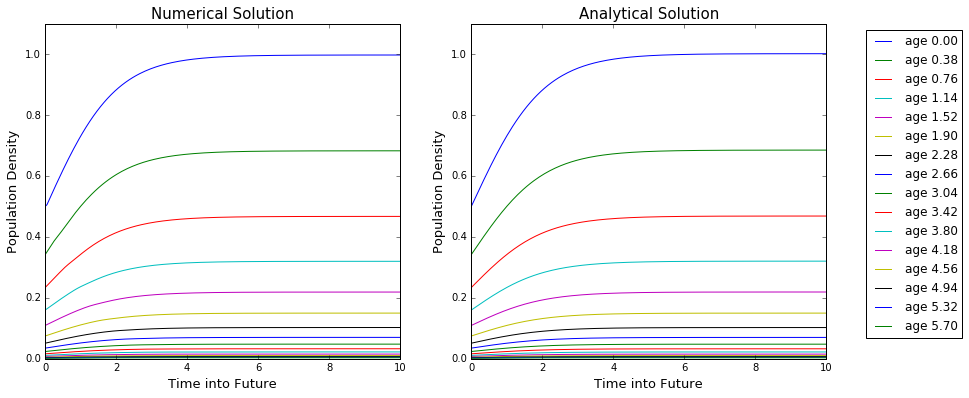

In [7]:
# generate grid
tsteps = 200
asteps = 80
t_range = np.linspace(0,T,tsteps)
x_range = np.linspace(0,A,asteps)
deltat = t_range[1]-t_range[0]
deltax = x_range[1]-x_range[0]
nu = deltat/float(deltax)
age_wave = np.zeros((len(x_range),len(t_range)))

# initialize grid with starting population distribution
phi0 = [u0(x) for x in x_range]
age_wave[:,0] = phi0

# upwind scheme
for n in range(1, age_wave.shape[1]):
    for j in range(1,age_wave.shape[0]):
        z = deltax*np.sum(age_wave[:,n-1])
        rhs = -mu(x_range[j],z,t_range[n-1]) * age_wave[j,n-1]
        age_wave[j,n] = deltat*(rhs - (age_wave[j,n-1]-age_wave[j-1,n-1])/deltax) + age_wave[j,n-1]
    z = deltax*np.sum(age_wave[:,n])
    alpha = [beta(j,z,t_range[n]) for j in x_range]
    age_wave[0,n] = deltax * np.dot(alpha, age_wave[:,n])

# plot analytical vs numerical solution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for ind, a in enumerate(x_range):
    if ind%5==0:
        plt.plot(t_range, age_wave[ind,:], label='age %0.2f'% a)
# plt.legend(bbox_to_anchor=(1.2,1))
plt.title("Numerical Solution", fontsize=15)
plt.xlabel("Time into Future", fontsize=13)
plt.ylabel("Population Density", fontsize=13)
plt.ylim([0,1.1])

plt.subplot(1,2,2)
for ind, a in enumerate(x_range):
    if ind%5==0:
        plt.plot(t_range, [u_analytical(a,t) for t in t_range], label='age %0.2f'% a)
plt.legend(bbox_to_anchor=(1.4,1))
plt.title("Analytical Solution", fontsize=15)
plt.xlabel("Time into Future", fontsize=13)
plt.ylabel("Population Density", fontsize=13)
plt.ylim([0,1.1]);
plt.savefig('plots/pde_error_analysis.png', bbox_inches='tight')

### 2iii. Error Analysis

In [8]:
# composite rectangular rule
def composite_rectangular(density_grid, x_range, x_lower, x_upper, t_range, t_lower, t_upper):
    x_lower_ind = -1
    for ind,x in enumerate(x_range):
        if x>=x_lower:
            x_lower_ind=ind
            break
    x_upper_ind = -1     
    for ind,x in enumerate(x_range):
        if x>=x_upper:
            x_upper_ind=ind
            break
            
    t_lower_ind = -1
    for ind,t in enumerate(t_range):
        if t>=t_lower:
            t_lower_ind=ind
            break
    t_upper_ind = -1     
    for ind,t in enumerate(t_range):
        if t>=t_upper:
            t_upper_ind=ind
            break
            
    I = 0
    for x_ind in range(x_lower_ind,x_upper_ind):
        for t_ind in range(t_lower_ind,t_upper_ind):
            I += density_grid[x_ind,t_ind]
    I = I * (x_range[1]-x_range[0]) * (t_range[1]-t_range[0])
    return I

    

In [9]:
# composite simpson rule
# possibly still has kinks
# composite quad used preferentially
def composite_simpson(density_grid, x_range, x_lower, x_upper, t_range, t_lower, t_upper):
    x_lower_ind = -1
    for ind,x in enumerate(x_range):
        if x>=x_lower:
            x_lower_ind=ind
            break
    x_upper_ind = -1     
    for ind,x in enumerate(x_range):
        if x>=x_upper:
            x_upper_ind=ind
            break
            
    t_lower_ind = -1
    for ind,t in enumerate(t_range):
        if t>=t_lower:
            t_lower_ind=ind
            break
    t_upper_ind = -1     
    for ind,t in enumerate(t_range):
        if t>=t_upper:
            t_upper_ind=ind
            break
            
    # collapse across time
    Ix = density_grid[:,t_lower_ind] + density_grid[:,t_upper_ind]
    for t_ind in range(t_lower_ind+1,t_upper_ind):
        if t_ind%2==1:
            Ix += 4*density_grid[:,t_ind]
        else:
            Ix += 2*density_grid[:,t_ind]
    Ix = Ix * (t_range[1]-t_range[0])/3.
    
    # collapse across age 
    I = Ix[x_lower_ind] + Ix[x_upper_ind]
    for x_ind in range(x_lower_ind+1,x_upper_ind):
        if x_ind%2==1:
            I += 4*Ix[x_ind]
        else:
            I += 2*Ix[x_ind]
    I = I * (x_range[1]-x_range[0])/3.            
    return I

    

In [10]:
def numerical_scheme_error(tsteps=200, asteps=20, plot_total_pop=False):
    # generate grid
    t_range = np.linspace(0,T,tsteps)
    x_range = np.linspace(0,A,asteps)
    deltat = t_range[1]-t_range[0]
    deltax = x_range[1]-x_range[0]
    nu = deltat/float(deltax)
    age_wave = np.zeros((len(x_range),len(t_range)))

    # initialize grid with starting population distribution
    phi0 = [u0(x) for x in x_range]
    age_wave[:,0] = phi0

    # upwind scheme
    for n in range(1, age_wave.shape[1]):
        for j in range(1,age_wave.shape[0]):
            z = deltax*np.sum(age_wave[:,n-1])
            rhs = -mu(x_range[j],z,t_range[n-1]) * age_wave[j,n-1]
            age_wave[j,n] = deltat*(rhs - (age_wave[j,n-1]-age_wave[j-1,n-1])/deltax) + age_wave[j,n-1]
        z = deltax*np.sum(age_wave[:,n])
        alpha = [beta(j,z,t_range[n]) for j in x_range]
        age_wave[0,n] = deltax * np.dot(alpha, age_wave[:,n])
        
    age_analytical = np.zeros(age_wave.shape)
    for ind_x, x in enumerate(x_range): 
        for ind_t, t in enumerate(t_range):
            age_analytical[ind_x, ind_t] = u_analytical(x,t)
     
    if plot_total_pop==True:
        # sanity check total population
        total_pop_analytical = np.sum(age_analytical, axis=0)*deltax
        total_pop_numerical = np.sum(age_wave, axis=0)*deltax
        plt.plot(t_range, total_pop_analytical, label='analytical')
        plt.plot(t_range, total_pop_numerical, label='numerical')
        plt.legend()
    
    # express error as total population 10 years out
    truth = composite_rectangular(age_analytical, x_range, 0, 6, t_range, 9, 10)
    est = composite_rectangular(age_wave, x_range, 0, 6, t_range, 9, 10)
    error = abs(est-truth)/truth
    return error 


0.039630470061139678

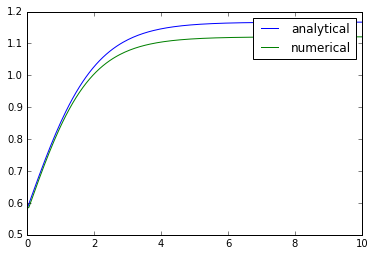

In [11]:
# example usage
numerical_scheme_error(200,20,True)

In [12]:
age_wave.shape

(80L, 200L)

In [13]:
t_steps_list = [200,400,800,1600]
a_steps_list = [10,20,40,80]
table = []
for t_steps in t_steps_list:
    for a_steps in a_steps_list:
        error = np.round(numerical_scheme_error(tsteps=t_steps, asteps=a_steps),6)
        row = [t_steps, a_steps, error]
        table.append(row)
        
# pretty print
pd.DataFrame(table, 
             columns=['t_steps','a_steps','error'])

,t_steps,a_steps,error
0,200,10,0.188118
1,200,20,0.039630
2,200,40,0.008740
3,200,80,0.002090
4,400,10,0.188137
5,400,20,0.039638
6,400,40,0.008747
7,400,80,0.002097
8,800,10,0.188147
9,800,20,0.039643


# Application to real data

### 3i. Initial population

In [14]:
# set year from which to generate projections
YEAR_TO_START = 1990

In [15]:
# import
input_df = pd.read_csv('data\YearAgePopBirthDeath_deathsAdjusted.csv')
input_df = input_df[[
        "YEAR",
        "AGE GROUP",
        "POPULATION",
        "BIRTH RATE",
        "DEATH RATE",
    ]]

# set cases in which death rate is estimated to an obvious flag
input_df.ix[input_df["YEAR"]<1999, 'DEATH RATE'] = -9999


In [16]:
# get population at YEAR_TO_START
input_df["BIRTH RATE"] = input_df["BIRTH RATE"]/2.
input_df_START = input_df[input_df.YEAR==YEAR_TO_START].copy()
input_df_START["AGEGROUPMID"] = [2,10,20,30,40,50,60,70,80]
input_df_START["BUCKETSIZE"] = [5,10,10,10,10,10,10,10,15]
input_df_START["POPULATIONSCALED"] = input_df_START["POPULATION"]/input_df_START["BUCKETSIZE"]
# WAR INTERVENTION
# input_df_2015.loc[input_df_2015.AGEGROUPMID == 20, 'DEATH RATE'] = 0.3
input_df_START

,YEAR,AGE GROUP,POPULATION,BIRTH RATE,DEATH RATE,AGEGROUPMID,BUCKETSIZE,POPULATIONSCALED
0,1990,<4,18887075.0,0.00000,-9999.0,2,5,3777415.0
1,1990,5-14,35360381.0,0.00070,-9999.0,10,10,3536038.1
2,1990,15-24,36193896.0,0.04410,-9999.0,20,10,3619389.6
3,1990,25-34,42574509.0,0.05025,-9999.0,30,10,4257450.9
4,1990,35-44,37649458.0,0.00930,-9999.0,40,10,3764945.8
5,1990,45-54,25242747.0,0.00010,-9999.0,50,10,2524274.7
6,1990,55-64,21096727.0,0.00000,-9999.0,60,10,2109672.7
7,1990,65-74,18121686.0,0.00000,-9999.0,70,10,1812168.6
8,1990,75+,13181238.0,0.00000,-9999.0,80,15,878749.2


In [17]:
# composite simpson rule
def composite_simpson_basic(func, n, lower, upper):
    nodes = np.linspace(lower, upper, n+1)
    h = (upper-lower)/float(n)
    I = func(nodes[0]) + func(nodes[n])
    for i in range(1,n):
        if i%2==1:
            I += 4*func(nodes[i])
        else:
            I += 2*func(nodes[i])
    return h/3. * I
    

composite quad of spline 243112092.504
observed total pop 248307717.0


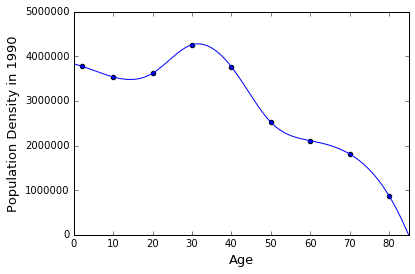

In [18]:
# cubic spline
pop_spline0 = CubicSpline(input_df_START["AGEGROUPMID"].values, input_df_START["POPULATIONSCALED"].values)
def pop_spline(i):
    if pop_spline0(i)<0:
        return 0
    else:
        return pop_spline0(i)
pop_spline_plot = [pop_spline(i) for i in np.linspace(0,85,2000)]

plt.scatter(input_df_START["AGEGROUPMID"].values, 
            input_df_START["POPULATIONSCALED"].values)
plt.plot(np.linspace(0,85,2000), pop_spline_plot)
plt.xlim([0,85])
plt.xlabel('Age', fontsize=13)
plt.ylabel('Population Density in 1990', fontsize=13)
plt.ylim([0,5000000])
plt.savefig('plots/initial_1990.png', bbox_inches='tight')

print 'composite quad of spline', composite_simpson_basic(pop_spline, 2000, 0, 85)
print 'observed total pop', np.sum(input_df_START["POPULATION"].values)


### 3ii. Birth rate multidimensional cubic spline

In [19]:
# multidimesional cubic spline
input_df["AGEGROUPMID"] = [2,10,20,30,40,50,60,70,80]*(2015-1989)
X = input_df["AGEGROUPMID"].values
Y = input_df["YEAR"].values-1990
Z = input_df["BIRTH RATE"].values
interp_birth = Rbf(X, Y, Z, function='cubic')


In [20]:
# extrapolation protocol
weight = 1
def birth_spline(x, t): 
    if x<12 or x>45:
        return 0
    elif interp_birth(x, t)>0 and t>25:
        return weight*(interp_birth(x,25)/2+interp_birth(x,24)/2) + (1-weight)*interp_birth(x,t)
    elif interp_birth(x, t)>0 and t<=25:
        return interp_birth(x,t)
    else:
        return 0
    

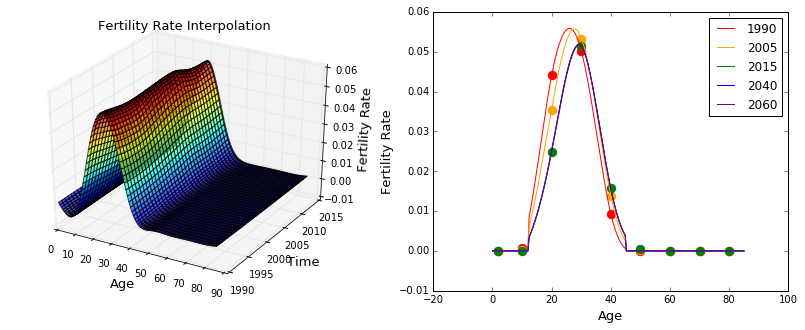

In [21]:
# PLOT
fig = plt.figure(figsize=(14,5))
delta = 0.05
xx = np.arange(0, 85, delta) # x
yy = np.arange(1990, 2015+delta, delta) # t
yy = yy - 1990
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.shape[0], XX.shape[1]))
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        ZZ[i,j] = interp_birth(XX[i,j],YY[i,j])
        
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(XX, YY+1990, ZZ, cmap=cm.jet, alpha=.7, rstride=15, cstride=15)

plt.title('Fertility Rate Interpolation', fontsize=13)
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel(r'Fertility Rate', fontsize=13)

ax = fig.add_subplot(1, 2, 2)
YEAR_PLOT_LIST = [1990,2005,2015,2040,2060]
pal = ['red','orange','green','blue','purple']

for ind, YEAR_PLOT in enumerate(YEAR_PLOT_LIST):
    ax.plot(np.linspace(0,85,200), 
             [birth_spline(x, YEAR_PLOT-1990) for x in np.linspace(0,85,200)], 
             label=YEAR_PLOT,
             color=pal[ind])
plt.legend()
for ind, YEAR_PLOT in enumerate(YEAR_PLOT_LIST):
    if YEAR_PLOT in np.arange(1990,2016,1):
        ax.scatter(input_df[input_df["YEAR"]==YEAR_PLOT]["AGEGROUPMID"],
                    input_df[input_df["YEAR"]==YEAR_PLOT]["BIRTH RATE"],
                    s=70,
                    color=pal[ind])
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Fertility Rate', fontsize=13)
plt.savefig('plots/birthrate_spline.png', bbox_inches='tight')

### 3iii. Death rate multidimensional cubic spline

In [22]:
# multidimesional cubic spline
input_df["AGEGROUPMID"] = [2,10,20,30,40,50,60,70,80]*(2015-1989)
input_df_death = input_df[input_df["YEAR"]>=1999]
X = input_df_death["AGEGROUPMID"].values
Y = input_df_death["YEAR"].values-1999
Z = input_df_death["DEATH RATE"].values
interp_death = Rbf(X, Y, Z, function='cubic')


In [23]:
# extrapolation protocol
weight = 1
def death_spline(x, t): 
    if interp_death(x,t)<0:
        return 0
    elif interp_death(x,t)>1:
        return 1
    elif t>25:
        return weight*(interp_death(x,25)/2+interp_death(x,24)/2) + (1-weight)*interp_death(x,t)
    elif t<9:
        return weight*(interp_death(x,9)/2+interp_death(x,10)/2) + (1-weight)*interp_death(x,t)
    else:
        return interp_death(x,t)
    

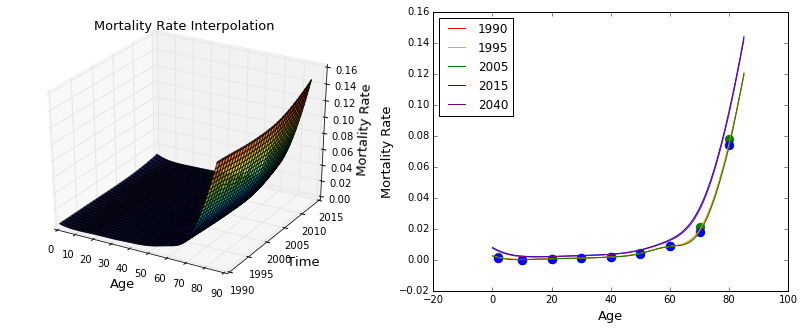

In [24]:
# PLOT
fig = plt.figure(figsize=(14,5))
delta = 0.05
xx = np.arange(0, 85, delta) # x
yy = np.arange(1990, 2015+delta, delta) # t
yy = yy - 1990
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.shape[0], XX.shape[1]))
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        ZZ[i,j] = interp_death(XX[i,j],YY[i,j])
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(XX, YY+1990, ZZ, cmap=cm.jet, alpha=.7, rstride=15, cstride=15)

plt.title('Mortality Rate Interpolation', fontsize=13)
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel(r'Mortality Rate', fontsize=13)

ax = fig.add_subplot(1, 2, 2)

YEAR_PLOT_LIST = [1990,1995,2005,2015,2040]
pal = ['red','orange','green','blue','purple']

for ind, YEAR_PLOT in enumerate(YEAR_PLOT_LIST):
    plt.plot(np.linspace(0,85,200), 
             [death_spline(x, YEAR_PLOT-1990) for x in np.linspace(0,85,200)], 
             label=YEAR_PLOT,
             color=pal[ind])
plt.legend(loc=2)
for ind, YEAR_PLOT in enumerate(YEAR_PLOT_LIST):
    if YEAR_PLOT in np.arange(1999,2016,1):
        plt.scatter(input_df_death[input_df_death["YEAR"]==YEAR_PLOT]["AGEGROUPMID"],
                    input_df_death[input_df_death["YEAR"]==YEAR_PLOT]["DEATH RATE"],
                    s=70,
                    color=pal[ind])
        
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Mortality Rate', fontsize=13)
plt.savefig('plots/deathrate_spline.png', bbox_inches='tight')

### 3iv. Apply numerical scheme

In [25]:
# mortality rate
def mu(x,z,t):
    return death_spline(x ,t)

# birth rate
def beta(x,z,t):
    return birth_spline(x ,t)

# initial population distribution by age
def u0(x):
    return pop_spline(x)


In [26]:
def numerical_scheme_upwind(tsteps=200, asteps=100, A=80, T=50):
    # generate grid
    t_range = np.linspace(0,T,tsteps)
    x_range = np.linspace(0,A,asteps)
    deltat = t_range[1]-t_range[0]
    deltax = x_range[1]-x_range[0]
    nu = deltat/float(deltax)
    age_wave = np.zeros((len(x_range),len(t_range)))

    # initialize grid with starting population distribution
    phi0 = [u0(x) for x in x_range]
    age_wave[:,0] = phi0

    # upwind scheme
    for n in range(1, age_wave.shape[1]):
        for j in range(1,age_wave.shape[0]):
            z = deltax*np.sum(age_wave[:,n-1])
            rhs = -mu(x_range[j],z,t_range[n-1]) * age_wave[j,n-1]
            age_wave[j,n] = deltat*(rhs - (age_wave[j,n-1]-age_wave[j-1,n-1])/deltax) + age_wave[j,n-1]
        z = deltax*np.sum(age_wave[:,n])
        alpha = [beta(j,z,t_range[n]) for j in x_range]
        age_wave[0,n] = deltax * np.dot(alpha, age_wave[:,n])
        
    return t_range, x_range, age_wave


**long running cell**

In [27]:
%%time
A = 90
T = 30
asteps = A*3+1
tsteps = T*50+1
t_range, x_range, age_wave = numerical_scheme_upwind(tsteps=tsteps, asteps=asteps, A=A, T=T)

Wall time: 1min 18s


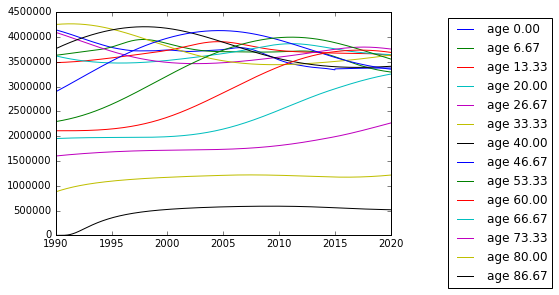

In [28]:
for ind, a in enumerate(x_range):
    if ind%20==0:
        plt.plot(YEAR_TO_START+t_range, age_wave[ind,:], label='age %0.2f'% a)
plt.legend(bbox_to_anchor=(1.5,1))

In [29]:
# sanity check, ensure total pop is approx right
print 'composite simpson of numerically derived population density at t0:', composite_simpson(age_wave, x_range, 0, 90, t_range, 0, 1)
print 'composite rectangular of numerically derived population densityat t0:', composite_rectangular(age_wave, x_range, 0, 90, t_range, 0, 1)
print 'observed total pop at t0:', np.sum(input_df_START["POPULATION"].values)

composite simpson of numerically derived population density at t0: 244511014.362
composite rectangular of numerically derived population densityat t0: 245170685.595
observed total pop at t0: 248307717.0


In [30]:
x_range_1990 = x_range.copy()
t_range_1990 = t_range.copy()
age_wave_1990 = age_wave.copy()

### 3v. Break down projections by age group

In [31]:
bucket_lower = [0,5,15,25,34,45,55,65,75]
bucket_upper = bucket_lower[1:] + [A]
years = np.arange(1990,2016)
boundaries = list(product(years, zip(bucket_lower, bucket_upper)))

# reconstruct dataframe
for_df = []
for row in boundaries:
    year = row[0]
    age_low = row[1][0]
    age_hig = row[1][1]
    pop_proj = composite_rectangular(age_wave, x_range, age_low, age_hig, t_range, year-1990, year-1990+1)
    for_df.append((year,age_low,age_hig,pop_proj))
    
projection_df = pd.DataFrame(for_df, columns=['YEAR','AGELOW','AGEHIGH','POPPROJ'])
projection_df["AGE GROUP"] = input_df["AGE GROUP"].values
projection_df["POPULATION"] = input_df["POPULATION"].values
projection_df.head(10)

,YEAR,AGELOW,AGEHIGH,POPPROJ,AGE GROUP,POPULATION
0,1990,0,5,1.910667e+07,<4,18887075.0
1,1990,5,15,3.565643e+07,5-14,35360381.0
2,1990,15,25,3.627458e+07,15-24,36193896.0
3,1990,25,34,3.751697e+07,25-34,42574509.0
4,1990,34,45,4.212428e+07,35-44,37649458.0
5,1990,45,55,2.633266e+07,45-54,25242747.0
6,1990,55,65,2.116586e+07,55-64,21096727.0
7,1990,65,75,1.801978e+07,65-74,18121686.0
8,1990,75,90,8.973439e+06,75+,13181238.0
9,1991,0,5,1.941387e+07,<4,19192292.0


In [32]:
projection_df.to_csv("data/pde_project_from_1990.csv")

### 4i. Repeat process but project from 2015

In [33]:
# set year from which to generate projections
YEAR_TO_START = 2015

### Initial population distribution

In [34]:
# get population at YEAR_TO_START
input_df["BIRTH RATE"] = input_df["BIRTH RATE"]/2.
input_df_START = input_df[input_df.YEAR==YEAR_TO_START].copy()
input_df_START["AGEGROUPMID"] = [2,10,20,30,40,50,60,70,80]
input_df_START["BUCKETSIZE"] = [5,10,10,10,10,10,10,10,15]
input_df_START["POPULATIONSCALED"] = input_df_START["POPULATION"]/input_df_START["BUCKETSIZE"]
# WAR INTERVENTION
# input_df_2015.loc[input_df_2015.AGEGROUPMID == 20, 'DEATH RATE'] = 0.3
input_df_START

,YEAR,AGE GROUP,POPULATION,BIRTH RATE,DEATH RATE,AGEGROUPMID,BUCKETSIZE,POPULATIONSCALED
225,2015,<4,19907281.0,0.000000,0.001377,2,5,3.981456e+06
226,2015,5-14,41109506.0,0.000050,0.000132,10,10,4.110951e+06
227,2015,15-24,43848216.0,0.012400,0.000695,20,10,4.384822e+06
228,2015,25-34,44137202.0,0.025712,0.001167,30,10,4.413720e+06
229,2015,35-44,40589783.0,0.007838,0.001801,40,10,4.058978e+06
230,2015,45-54,43188161.0,0.000200,0.004040,50,10,4.318816e+06
231,2015,55-64,40877819.0,0.000000,0.008753,60,10,4.087782e+06
232,2015,65-74,27550517.0,0.000000,0.017968,70,10,2.755052e+06
233,2015,75+,20210335.0,0.000000,0.074084,80,15,1.347356e+06


composite quad of spline 314544532.874
observed total pop 321418820.0


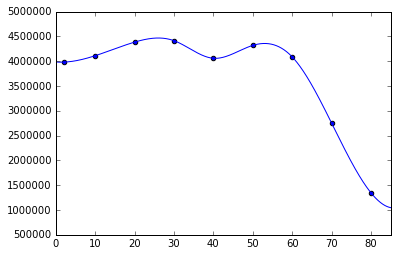

In [ ]:
# cubic spline
pop_spline = CubicSpline(input_df_START["AGEGROUPMID"].values, input_df_START["POPULATIONSCALED"].values)
pop_spline_plot = [pop_spline(i) for i in np.linspace(0,85,2000)]

plt.scatter(input_df_START["AGEGROUPMID"].values, 
            input_df_START["POPULATIONSCALED"].values)
plt.plot(np.linspace(0,85,2000), pop_spline_plot)
plt.xlim([0,85])

print 'composite quad of spline', composite_simpson_basic(pop_spline, 200, 0, 85)
print 'observed total pop', np.sum(input_df_START["POPULATION"].values)


**Really long running cell**

In [ ]:
%%time
A = 90
T = 55
asteps = A*3+1
tsteps = T*50+1
t_range, x_range, age_wave = numerical_scheme_upwind(tsteps=tsteps, asteps=asteps, A=A, T=T)

In [ ]:
for ind, a in enumerate(x_range):
    if ind%20==0:
        plt.plot(YEAR_TO_START+t_range, age_wave[ind,:], label='age %0.2f'% a)
plt.legend(bbox_to_anchor=(1.5,1))

In [ ]:
# plot results
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
xx = x_range_1990
yy = t_range_1990
XX, YY = np.meshgrid(yy, xx)
ax.plot_surface(YY, XX+1990, age_wave_1990, cmap=cm.jet, alpha=.5, rstride=5, cstride=10)
plt.title('Projecting from 1990', fontsize=13)
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Population Density', fontsize=13)

ax = fig.add_subplot(1, 2, 2, projection='3d')
xx = x_range
yy = t_range
XX, YY = np.meshgrid(yy, xx)
ax.plot_surface(YY, XX+2015, age_wave, cmap=cm.jet, alpha=.5, rstride=5, cstride=20)
plt.title('Projecting from 2015', fontsize=13)
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Population Density', fontsize=13)

fig.savefig('plots/Population Density Estimates.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plot actual data interpolated as a sanity check
# Note that this splinish approach is appropriate before 2015 when we are the "interpolation region"
# However we expect its performance to degrade heavily after 2015 in the "extrapolation region"
input_df["AGEGROUPMID"] = [2,10,20,30,40,50,60,70,80]*(2015-1989) 
input_df["BUCKETSIZE"] = [5,10,10,10,10,10,10,10,15]*(2015-1989) 
input_df["POPULATIONSCALED"] = input_df["POPULATION"]/input_df["BUCKETSIZE"]
X = input_df["AGEGROUPMID"].values
Y = input_df["YEAR"].values-1990
Z = input_df["POPULATIONSCALED"].values
interp_pop = Rbf(X, Y, Z, function='cubic')

delta = 0.05
xx = np.arange(0, 85, delta) # x
yy = np.arange(1990, 2015+delta, delta) # t
yy = yy - 1990
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.shape[0], XX.shape[1]))
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        ZZ[i,j] = interp_pop(XX[i,j],YY[i,j])

fig = plt.figure(figsize=(7,8))        
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY+1990, ZZ, cmap=cm.jet, alpha=.7, rstride=8, cstride=8)
# 
plt.title('Population Density Spline Using Actual Data', fontsize=13)
ax.set_xlabel('Age', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel(r'Population Density', fontsize=13)

In [ ]:
# sanity check, ensure total pop is approx right
print 'composite simpson of numerically derived population density at t0:', composite_simpson(age_wave, x_range, 0, 90, t_range, 0, 1)
print 'composite rectangular of numerically derived population densityat t0:', composite_rectangular(age_wave, x_range, 0, 90, t_range, 0, 1)
print 'observed total pop at t0:', np.sum(input_df_START["POPULATION"].values)

In [ ]:
bucket_lower = [0,5,15,25,34,45,55,65,75]
bucket_upper = bucket_lower[1:] + [A]
years = np.arange(2015,2065)
boundaries = list(product(years, zip(bucket_lower, bucket_upper)))

# reconstruct dataframe
for_df = []
for row in boundaries:
    year = row[0]
    age_low = row[1][0]
    age_hig = row[1][1]
    pop_proj = composite_rectangular(age_wave, x_range, age_low, age_hig, t_range, year-2015, year-2015+1)
    for_df.append((year,age_low,age_hig,pop_proj))
    
projection_df = pd.DataFrame(for_df, columns=['YEAR','AGELOW','AGEHIGH','POPPROJ'])
projection_df.head(10)

In [ ]:
projection_df.to_csv("data/pde_project_from_2015.csv")

### 4ii Make retirement age 70 and rechunk data

In [ ]:
bucket_lower = [0,5,15,25,34,45,55,70,75]
bucket_upper = bucket_lower[1:] + [A]
years = np.arange(2015,2065)
boundaries = list(product(years, zip(bucket_lower, bucket_upper)))

# reconstruct dataframe
for_df = []
for row in boundaries:
    year = row[0]
    age_low = row[1][0]
    age_hig = row[1][1]
    pop_proj = composite_rectangular(age_wave, x_range, age_low, age_hig, t_range, year-2015, year-2015+1)
    for_df.append((year,age_low,age_hig,pop_proj))
    
projection_df = pd.DataFrame(for_df, columns=['YEAR','AGELOW','AGEHIGH','POPPROJ'])
projection_df.head(10)

In [ ]:
projection_df.to_csv("data/pde_project_from_2015_retirement_age_70.csv")

### 4iii Make retirement age 67 and rechunk data

In [ ]:
bucket_lower = [0,5,15,25,34,45,55,67,75]
bucket_upper = bucket_lower[1:] + [A]
years = np.arange(2015,2065)
boundaries = list(product(years, zip(bucket_lower, bucket_upper)))

# reconstruct dataframe
for_df = []
for row in boundaries:
    year = row[0]
    age_low = row[1][0]
    age_hig = row[1][1]
    pop_proj = composite_rectangular(age_wave, x_range, age_low, age_hig, t_range, year-2015, year-2015+1)
    for_df.append((year,age_low,age_hig,pop_proj))
    
projection_df = pd.DataFrame(for_df, columns=['YEAR','AGELOW','AGEHIGH','POPPROJ'])
projection_df.head(10)

In [ ]:
projection_df.to_csv("data/pde_project_from_2015_retirement_age_67.csv")